<h2>1 - Data Preperation<h2>

<h3>1.1 - Importing Data/Libraries</h3>

<p> We begin by importing the stock and reddit data we have gathered.</p>

In [313]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np


In [314]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

In [315]:
#Subreddit Data
df1.head()

,Economics
2022-09-01 12:40:00,"{'polarity': 0.4, 'subjectivity': 0.7000000000..."
2022-09-01 12:42:00,"{'polarity': 0.5, 'subjectivity': 0.6000000000..."
2022-09-01 12:43:00,"{'polarity': 0.1, 'subjectivity': 0.4, 'compou..."
2022-09-01 12:44:00,"{'polarity': 0.5, 'subjectivity': 0.925, 'comp..."
2022-09-01 12:47:00,"{'polarity': 0.1071428571, 'subjectivity': 0.3..."


In [316]:
#Stock Data
df2.head()

,Unnamed: 0,Adj Close
0,2022-08-29 09:30:00-04:00,369.648010
1,2022-08-29 09:31:00-04:00,369.799988
2,2022-08-29 09:33:00-04:00,370.220001
3,2022-08-29 09:34:00-04:00,370.549988
4,2022-08-29 09:35:00-04:00,370.299988


<h3>1.2 - Preparing The Subreddit Sentiment Data </h3>

In [317]:
#Bring out date/time data from index
df1.reset_index(inplace=True)
df1['index'] = pd.to_datetime(df1['index'])
df1['date'] = df1['index'].dt.date

#Group times and their corresponding sentiment data into a list by day
df1['time'] = df1['index']
df1 = df1.groupby('date').agg(list)
df1.reset_index(inplace=True)

#Create final dataframe
df1 = df1[['date', 'time', 'Economics']]
df1.head()

,date,time,Economics
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000..."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
2,2022-09-03,"[2022-09-03 09:36:00, 2022-09-03 09:38:00, 202...","[{'polarity': 0.1, 'subjectivity': 1.3, 'compo..."
3,2022-09-04,"[2022-09-04 09:42:00, 2022-09-04 09:43:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."
4,2022-09-05,"[2022-09-05 12:56:00, 2022-09-05 13:00:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo..."


<h3>1.3 - Preparing The Stock Price Data<h3>

In [318]:
#Bring out date/time data from index
df2['date_time'] = pd.to_datetime(df2['Unnamed: 0'])
df2['date'] = df2['date_time'].dt.date
df2['time'] = df2['date_time'].dt.tz_localize(None)

#Group times and their corresponding price data into a list by day
df2 = df2.groupby('date').agg(list)
df2.reset_index(inplace=True)

#Create Final Dataframe
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2 = df2[['price', 'date', 'time']]
df2.head(5)


,price,date,time
0,"[369.6480102539063, 369.7999877929688, 370.220...",2022-08-29,"[2022-08-29 09:30:00, 2022-08-29 09:31:00, 202..."
1,"[371.2200012207031, 370.760009765625, 371.0400...",2022-08-30,"[2022-08-30 09:30:00, 2022-08-30 09:31:00, 202..."
2,"[367.0400085449219, 367.0700073242188, 366.660...",2022-08-31,"[2022-08-31 09:30:00, 2022-08-31 09:31:00, 202..."
3,"[361.5299987792969, 360.8349914550781, 360.959...",2022-09-01,"[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202..."
4,"[367.3999938964844, 366.8800048828125, 366.709...",2022-09-02,"[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202..."


<h3>1.4 - Merging The Sentiment Data And Stock Price Data<h3>

In [319]:
#merge stock/sentiment data according to the date value
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.rename(columns={'time_x': 'sentiment_time', 'time_y':'stock_time'}, inplace=True)

#get rid of rows that have no sentiment data
df.dropna(inplace=True)
df['na'] = np.nan
df.head()

,date,sentiment_time,Economics,price,stock_time,na
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN


<h3>1.5 - Determining Percent Change In Price<h3>

In [320]:
def generate_price_dif(row):
    """
    Returns the difference between a price and the price at the next time step
    """
    prices = np.asarray(row['price'])
    price_shift = np.asarray(row['price'][1:] + row['price'][0:1])
    delta_price = price_shift-prices
    return delta_price

#Create the price difference/percent change columns using the above function
df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)

df.head()

,date,sentiment_time,Economics,price,stock_time,na,price_diff,percent_change
0,2022-09-01,"[2022-09-01 12:40:00, 2022-09-01 12:42:00, 202...","[{'polarity': 0.4, 'subjectivity': 0.700000000...","[361.5299987792969, 360.8349914550781, 360.959...","[2022-09-01 09:30:00, 2022-09-01 09:31:00, 202...",NaN,"[-0.69500732421875, 0.125, -0.3800048828125, -...","[-0.1922405682973575, 0.034641873144268434, -0..."
1,2022-09-02,"[2022-09-02 09:41:00, 2022-09-02 09:42:00, 202...","[{'polarity': 0.0, 'subjectivity': 0.0, 'compo...","[367.3999938964844, 366.8800048828125, 366.709...","[2022-09-02 09:30:00, 2022-09-02 09:31:00, 202...",NaN,"[-0.519989013671875, -0.170013427734375, -0.19...","[-0.14153212365550089, -0.04634033620575209, -..."
5,2022-09-06,"[2022-09-06 12:30:00, 2022-09-06 12:46:00, 202...","[{'polarity': 0.8, 'subjectivity': 1.0, 'compo...","[362.0299987792969, 361.6700134277344, 361.609...","[2022-09-06 09:30:00, 2022-09-06 09:31:00, 202...",NaN,"[-0.3599853515625, -0.060028076171875, -0.1149...","[-0.09943522712932877, -0.016597471159678894, ..."
6,2022-09-07,"[2022-09-07 12:40:00, 2022-09-07 12:46:00, 202...","[{'polarity': 0.1, 'subjectivity': 0.700000000...","[358.7699890136719, 359.3039855957031, 359.040...","[2022-09-07 09:30:00, 2022-09-07 09:31:00, 202...",NaN,"[0.53399658203125, -0.26397705078125, 0.130004...","[0.14884092827811768, -0.07346900155966622, 0...."
7,2022-09-08,"[2022-09-08 13:00:00, 2022-09-08 13:01:00, 202...","[{'polarity': -0.2, 'subjectivity': 0.0, 'comp...","[362.5960083007813, 362.9599914550781, 362.929...","[2022-09-08 09:30:00, 2022-09-08 09:31:00, 202...",NaN,"[0.36398315429681816, -0.029998779296818157, -...","[0.10038255964331692, -0.008265037470536463, -..."


<h2>2 - Visualizing Trends In News Sentiment and Stock Prices</h2>

<p>Visualizing the data should reveal trends in the prices that make be unintuitive given large sets of numbers. This should provide us with a solid basis for attempting to explore correlations in stock prices and news sentiment.</p>

<h3>2.1 - Plotting Sentiment Versus Price</h3>

<p>We begin by exploring the intesnity of sentiment per minute with data to the daily graph of our given stock.</p>

In [321]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
myFmt = mdates.DateFormatter('%H%:%M:%S')

class Analyzer:
    """
    Generator class which contains methods to generate data from subreddits/stock prices.
    Initializes with:
        - Subreddits: a list of subreddit titles where each title is a string
        - Dataframe: a pandas dataframe containing the stock prices per time interval
        - 
    """

    def __init__(self, subreddits, dataframe):
        self.subreddits = subreddits
        self.dataframe = dataframe
        self.df_dict = self.generate_daily_full(subreddits, dataframe)
        self.complete_markov = {subreddit:[] for subreddit in self.subreddits}
        self.combined_df_dict = None



    def convert(self, row, subreddit):
        """
        Convert subreddit to nested lists containing dict
        """

        lst = []
        for dct in row.loc[subreddit]:
            lst.append([dct])

        return lst
        


    def generate_daily_data(self, index, subreddit):
        """
        Creates a dataframe that is the result of merging the stock prices per time period
        and the subreddit specific data
        Inputs:
            - index: the index of the row being used to generate data
        Outputs:
            - Returns a pandas dataframe of daily subreddit/stock price data
        """
        
        #create a dictionary with a time key that has every minute ina 24 hour period
        d = self.dataframe.iloc[index][['date', 'na']].to_dict()
        d['time'] = pd.date_range(self.dataframe['date'].iat[index], freq='Min', periods=60*24, name='date')
        
        #create an empty dataframe with the index as the generated time
        df = pd.DataFrame(d)
        df.set_index(df['time'], inplace = True)
        df = df[[]]

        #create dataframe for each column of stock data we want time series for -> index is stock_time
        price_time_df = pd.DataFrame(self.dataframe.iloc[index]['price'], 
                                    index = self.dataframe.iloc[index]['stock_time'], 
                                    columns=['price'])

        percent_change_df = pd.DataFrame(self.dataframe.iloc[index]['percent_change'], 
                                        index = self.dataframe.iloc[index]['stock_time'], 
                                        columns=['percent_change'])
        
        #store created dataframes in a list to later be merged into one dataframe
        lst = [price_time_df, percent_change_df]

        #create dataframes of sentiment_data -> index is sentiment_time
        for subreddit in self.subreddits:
            reddit_df = pd.DataFrame(self.dataframe.iloc[index][subreddit], 
                                    index = self.dataframe.iloc[index]['sentiment_time'], 
                                    columns=['sentiment']).reset_index()

            sentiment_time_df = pd.json_normalize(reddit_df['sentiment'])
            sentiment_time_df['index'] = reddit_df['index']
            sentiment_time_df.set_index(['index'], inplace=True)
            lst.append(sentiment_time_df)
        
        #Create new Dataframe by joining all of the generated dataframes
        joined_df = df.join(lst)
        joined_df.reset_index(inplace=True)
        pd.to_datetime(joined_df['time'])
        
        return joined_df



    def generate_daily_full(self, subreddits, dataframe):
        """
        Generate a list of dataframes containing stock price and sentiments per time for each day in the dataset
        """

        dct = {}
        for subreddit in subreddits:
            dataframe[subreddit] = dataframe.apply(lambda row: self.convert(row, subreddit), axis = 1)
            dct[subreddit]=[self.generate_daily_data(i, subreddit) for i in range(len(dataframe))]

        return dct



    def markov_chain_data(self):
        """
        Adds a column to the daily dataframes indicating the markov bin the time interval falls into
        """

        for subreddit in self.subreddits:
            for df in self.df_dict[subreddit]:

                #generates a numpy array populated with values that correspond to precent changes -> new markov_bins column
                df['markov_bins'] = np.where(
                    (df['percent_change'] < -.1), 0, np.where(
                        ((df['percent_change'] > -.1) & (df['percent_change'] < 0)), 1, np.where(
                            ((df['percent_change'] < .1) & (df['percent_change'] > 0)), 2, np.where(
                                (df['percent_change'] > .1), 3, np.nan
                            ))))

                self.complete_markov[subreddit] += list(df.markov_bins.dropna())



    def plot_markov_hist(self, start_day, end_day):
        """
        Creates a bar graph of representing the frequencies that certain fluctuations in price
        occur in a given day
        Inputs:
            - start_day: an Integer that represents the first day to plot data from
            - end_day: an Integer that represents the last day to plot data from
        """

        #iterate through the range of start_day and end_day -> create a dictionary where the key is bin # and key is the count
        for day in range(start_day, end_day+1):
            lst = np.array(self.df_dict['Economics'][day].markov_bins.dropna())
            unique, counts = np.unique(lst, return_counts=True)
            dct = dict(zip(unique,counts))
            plt.bar(unique, counts)
            plt.show()
            


    def plot_subreddits_day(self, subreddits, plot_args, start_day, end_day, percent_change = False):
        """
        Plots the subreddit data from range start_day to end_day
        Inputs:
            - subreddits:
            - plot_args:
            - start_day:
            - end_day:
            - percent_change:
        """
        colors = {'neg': 'red','pos':'green', 'neu': 'blue'}
        for day in range(start_day, end_day+1): 
            for subreddit in subreddits:
                fig,ax = plt.subplots()
                if not percent_change:
                    ax.plot(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day].price, color="black",)
                else:
                    ax.plot(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day].percent_change, color="blue")
                    ax.set_ylim([-.3, .3])

                #ax.xaxis.set_major_formatter(myFmt)

                # set x-axis label
                ax.set_xlabel("Time", fontsize = 14)
                # set y-axis label
                ax.set_ylabel("Price", color="red", fontsize=14)
                ax2=ax.twinx()
                # make a plot with different y-axis using second axis object
                for arg in plot_args:
                    ax2.bar(self.df_dict[subreddit][day].time, self.df_dict[subreddit][day][arg] ,color=colors[arg], width = .002)
                ax2.set_ylabel("Sentiment",color="black",fontsize=14)
                fig.set_figwidth(15)
                fig.set_figheight(5)
                plt.show()


    def generate_train_test(self, index):
        """
        
        """
        for subreddit in self.subreddits:
            df_temp = pd.concat(self.df_dict[subreddit])
            for column in df_temp.columns:
                if column != 'time':
                    df_temp[column].fillna(value = df_temp[column].mean(), inplace=True)
            n = len(df_temp)
            
            train_df = df_temp[0:int(n*.7)]
            train_x = train_df.drop(['time', 'price'], axis=1)
            train_y = train_df[['price']]

            val_df = df_temp[int(n*.7):int(n*.9)]
            val_x = val_df.drop(['time', 'price'], axis=1)
            val_y = val_df[['price']]
            
            test_df = df_temp[int(n*.9):]
            test_x = test_df.drop(['time', 'price'], axis=1)
            test_y = test_df[['price']]

        return [(train_x, train_y), (val_x, val_y), (test_x, test_y)]

In [322]:
analyzer = Analyzer(['Economics'], df)

<p>Now lets explore the relationship between change in price and the sentiment intensities</p>

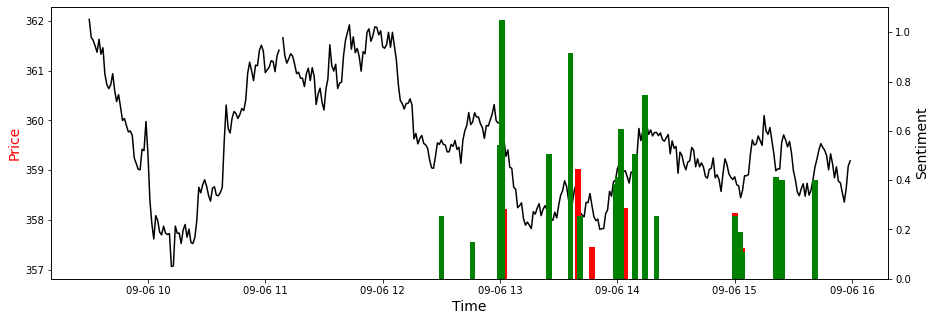

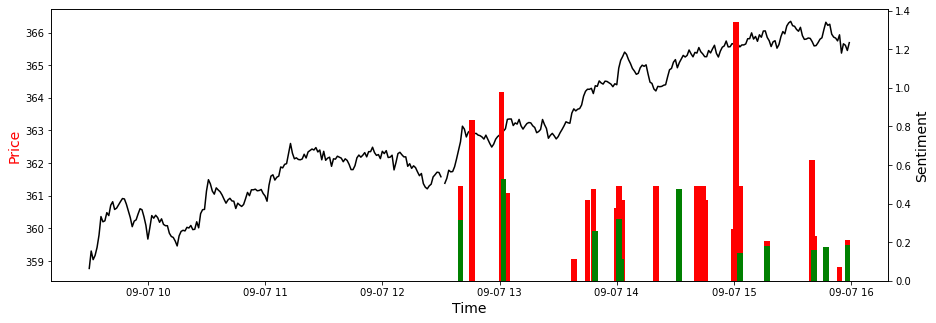

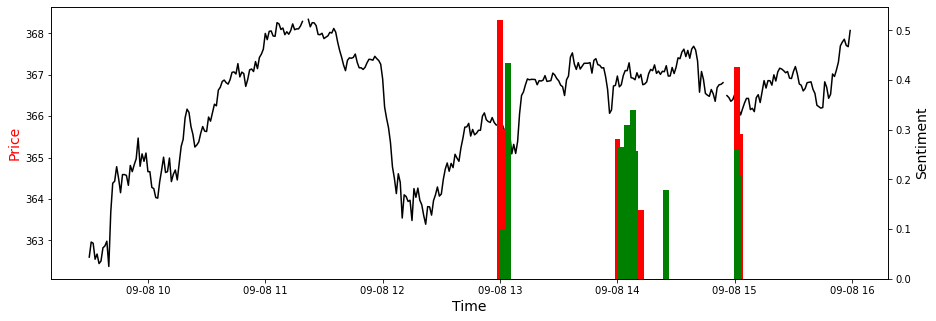

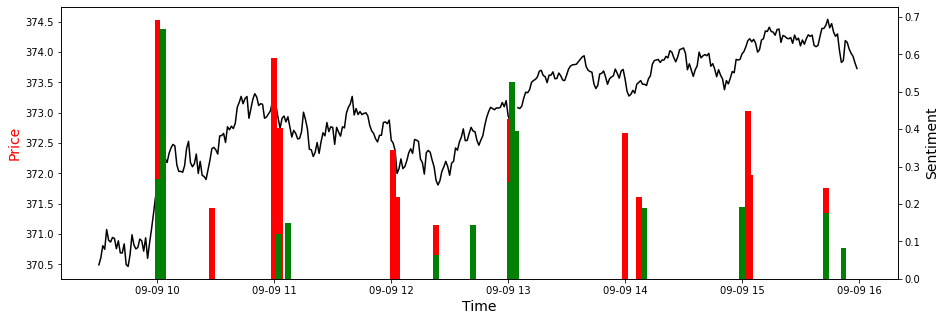

In [328]:
analyzer.plot_subreddits_day(['Economics'], ['neg', 'pos'], 2, 5)

<h3>Initial Hypothesis</h3>
<p>blah blah blah</p>

<h2>3 - Markov Chains<h2>

In [324]:
analyzer.markov_chain_data()

<h3>3.1 - Plotting Hist</h3>

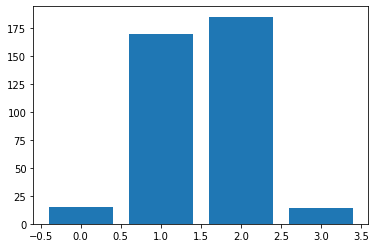

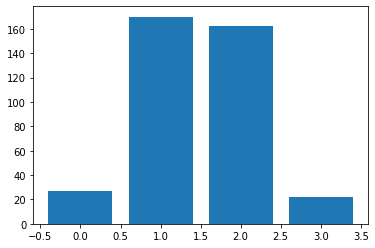

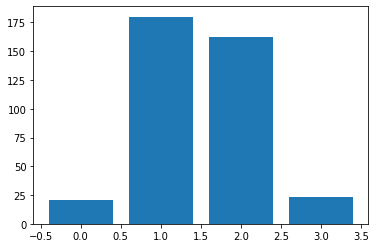

In [325]:
analyzer.plot_markov_hist(0,2)

<h3>3.2 - Nth Degree Markov Chains<h3>

In [326]:
from collections import defaultdict
import random

class Markov(Analyzer):
    
    def __init__(self):
        self.chain = None
        self.predictions = None


    def generate_chain(self, degree, data):
        dct = defaultdict(lambda: defaultdict(int))    
        for i in range((len(data) - degree - 1)):
            r = degree + i
            slice = tuple(data[i: r])
            dct[slice][data[r]] += 1

        for key, value in dct.items():
            sums = sum(value.values())
            for key2, value2 in value.items():
                dct[key][key2]= value2/sums
                dct[key] = dict(dct[key])
        self.chain = dict(dct)


    def predict(self, last, num):
        states = []
        
        for _step in range(num):
            rand_list = [] #contains the numbers 0, 1, 2, 3 in their proper frequency
            
            if tuple(last) not in self.chain.keys(): #check if the key exists in dict
                rand_list = [0,1,2,3]
                    
            else: 
                for key, value in self.chain[tuple(last)].items():
                    #calculate frequency
                    value *= 100
                    value = int(value//10)
                    rand_list += [key] * value #add number of elements to list matching the frequency
            
            #randomly pick from list of elements - equivalent to a weighted average
            state = rand_list[random.randint(0, len(rand_list) - 1)]
            states.append(state)
            last = last[1:] #shift last to the right in order to maintain order size
            last.append(state)

        self.predictions = states
        

    def mse(self, expected):
        #n-value
        length = len(self.predictions)
        error_sum = 0
        
        #iterate through all values and calculate individual errors
        for index in range(length):
            error_sum += (self.predictions[index] - expected[index])**2
        
        return error_sum/length


    def accuracy(self, expected):
        count = 0
        for index, value in enumerate(expected):
            if value == self.predictions[index]:
                count += 1
        return count/len(expected)


    def run(self, train, test, degree, trials):
        #initialize error as 0 and then add as trials progress
        cumulative_accuracy = 0
        error = 0
        for _trial in range(trials):
            self.generate_chain(degree, train)
            self.predict(test[:degree], len(test) - degree)
            cumulative_accuracy += self.accuracy(test[degree:])
            error += self.mse(test[degree:])
         
        return cumulative_accuracy/trials, error/trials


    def optimal_degree(self, train, test, trials, degrees):
        accuracy_plt = []
        mse_plt = []
        for i in degrees:
            accuracy, error = self.run(train, test, i, trials)
            accuracy_plt.append(accuracy)
            mse_plt.append(error)

        print(accuracy_plt.index(max(accuracy_plt)))
        print(max(accuracy_plt))
        plt.plot(accuracy_plt)
        plt.plot(mse_plt)
        plt.show()




3
0.46354733405875953


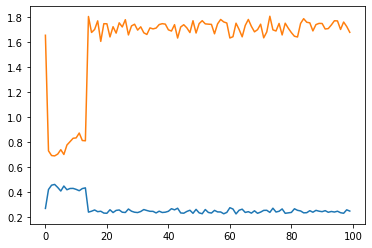

In [327]:
bins = analyzer.complete_markov['Economics']
train = list(bins[:int(len(bins) * .7)])
test = list(bins[int(len(bins) * .7):])
markov = Markov()
markov.optimal_degree(train, test, 1, range(100))

<h3>3.3 - Optimizing Nth Degree Markov Chains<h3>

<h2>4 - Deep Neural Network<h2>

<h2>5 - LSTM Networks<h2>